### Analysis
1. **Data loading and preprocessing**
    - Imports participant data, filters outliers, parses timestamps.
    - Derives metrics such as AI values and AI adherence rates.
    - Prints demographic data.
2. **Scores**
    - Plots mean pre, AI, post scores across conditions.
    - Predicts participants' scores.
3. **Rewards**
    - Plots mean reward per trial in the AI-assisted phase.
    - Predicts participants' rewards.
4. **AI adherence**
    - Plots score against AI adherence.
    - Plots AI adherence rate against trial number.
    - Predicts AI adherence.
5. **Counterfactual AI**
    - Plots adherence to the counterfactual AI.
    - Predicts adherence to the counterfactual AI.
    - Plots the counterfactual AI value against the trial number.
    - Predicts actual and counterfactual AI values.
6. **Ratings**
    - Plots AI usefulness rating against participant score.
    - Predicts participants' AI usefulness rating.
    - Prints the distribution of the ratings: usefulness (final), usefulness (per round), adherence (final).
7. **AI values**
    - Plots participant reward against AI value (point clouds and regression lines).
    - Predicts participant reward when the AI suggestion is and isn't followed.
    - Plots AI value against trial number.
    - Plots improvement on AI suggestion against trial number.
    - Predicts improvement on AI advice.
    - Predicts the AI value.
8. **Time**
    - Plots mean pre, AI, post completion times across conditions.
    - Predicts completion time.

In [103]:
import json
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import FixedLocator, MultipleLocator
from tqdm import tqdm
import statistics
import numpy as np
from math import sqrt
import pandas as pd
from datetime import datetime
from statsmodels.formula.api import mixedlm
from common import set_matplotlib_latex, plot_colours, Advisor, Selection, high_level_combination, set_axes_length
set_matplotlib_latex()
plot_width = 1.05
plot_height = 0.7

def ai_suggestion_value(landscape_data, suggestion):
    reward_scalar = landscape_data["rewardScalar"]
    coefficients_low = landscape_data["coefficientsLow"]
    coefficients_high = landscape_data["coefficientsHigh"]
    min_reward = landscape_data["minReward"]
    max_reward = landscape_data["maxReward"]
    low_suggestion = suggestion[0]
    high_suggestion = suggestion[1]
    ai_value = 0
    for i in range(len(low_suggestion)):
        ai_value += low_suggestion[i] * coefficients_low[i]
    for i in range(len(high_suggestion)):
        ai_value += high_suggestion[i] * coefficients_high[i]
    ai_value = ai_value * reward_scalar + 100
    ai_value = max(min_reward, min(max_reward, ai_value))
    ai_value = (ai_value - min_reward) / (max_reward - min_reward) * 100
    return ai_value

def is_ai_suggestion_followed(trial):
    suggestion = trial["suggestion"]
    combination = trial["combination"]
    low_suggestion = suggestion[0]
    high_suggestion = suggestion[1]
    for i in range(len(low_suggestion)):
        if low_suggestion[i] != 0:
            if low_suggestion[i] != combination[i]:
                return False
    high_combination = high_level_combination(combination)
    for i in range(len(high_suggestion)):
        if high_suggestion[i] != 0:
            if high_suggestion[i] != high_combination[i]:
                return False
    return True

def quantify_matched_ai(trial):
    suggestion = trial["suggestion"]
    combination = trial["combination"]
    low_suggestion = suggestion[0]
    high_suggestion = suggestion[1]
    nr_components = 0
    nr_matched = 0
    for i in range(len(low_suggestion)):
        if low_suggestion[i] != 0:
            nr_components += 1
            if low_suggestion[i] == combination[i]:
                nr_matched += 1
    high_combination = high_level_combination(combination)
    for i in range(len(high_suggestion)):
        if high_suggestion[i] != 0:
            nr_components += 1
            if high_suggestion[i] == high_combination[i]:
                nr_matched += 1
    return 100 * nr_matched / nr_components

def ai_referenced_parts_reward(trial, landscape_data):
    suggestion = trial["suggestion"]
    combination = trial["combination"]
    low_suggestion = suggestion[0]
    high_suggestion = suggestion[1]
    high_combination = high_level_combination(combination)
    reward = 0
    for i in range(len(low_suggestion)):
        if low_suggestion[i] != 0:
            reward += combination[i] * landscape_data["coefficientsLow"][i]
    for i in range(len(high_suggestion)):
        if high_suggestion[i] != 0:
            reward += high_combination[i] * landscape_data["coefficientsHigh"][i]
    reward = reward * landscape_data["rewardScalar"] + 100
    min_reward = landscape_data["minReward"]
    max_reward = landscape_data["maxReward"]
    reward = max(min_reward, min(max_reward, reward))
    reward = (reward - min_reward) / (max_reward - min_reward) * 100
    return reward

def quantify_coverages(landscape_data, trials):
    advisor = Advisor(landscape_data["blockNr1"], landscape_data["blockNr2"])
    max_rank = 12
    coverages = []
    for trial in trials:
        reward = trial["noisyReward"]
        combination = trial["combination"]
        advisor.update_with_selection(Selection(combination, reward))
        rank = advisor.selections_matrix_rank()
        coverage = 100 * rank / max_rank
        coverages.append(coverage)
    return coverages

def load_counterfactual_advisor_simulation():
    with open("../outputs/counterfactual_advisor/counterfactual_advisor.json") as file:
        return json.load(file)

def load_participants_data(data_path):
    participants_data = []
    counterfactual_advisor_data = load_counterfactual_advisor_simulation()
    with open(data_path) as file:
        all_data = json.load(file)
        for participant_data in tqdm(all_data):
            if not participant_data["outlier"]:
                rounds = participant_data["experimentData"]["roundsData"]
                participant_counterfactual_advisor = counterfactual_advisor_data[participant_data["id"]]
                rounds_data = []
                nr_assisted_round = 0
                for round_ in rounds:
                    landscape = round_["landscape"]
                    min_reward = landscape["minReward"]
                    max_reward = landscape["maxReward"]
                    trials = round_["trials"]
                    coverages = quantify_coverages(landscape, trials)
                    trial_nr = 0
                    for trial, coverage in zip(trials, coverages):
                        trial["relativeReward"] = (trial["noisyReward"] - min_reward) / (max_reward - min_reward) * 100
                        trial["timestamp"] = datetime.strptime(trial["timestamp"][:-1], "%Y-%m-%dT%H:%M:%S.%f")
                        trial["coverage"] = coverage
                        if round_["roundType"] == "assisted":
                            trial["relativeAiValue"] = ai_suggestion_value(landscape, trial["suggestion"])
                            trial["followedAi"] = 100 if is_ai_suggestion_followed(trial) else 0
                            trial["followedOtherAi"] = participant_counterfactual_advisor[nr_assisted_round]["aiFollowedFrequencies"][trial_nr]
                            trial["relativeOtherAiReward"] = participant_counterfactual_advisor[nr_assisted_round]["aiRewards"][trial_nr]
                            trial["matchedAi"] = quantify_matched_ai(trial)
                            trial["aiReferencedPartsReward"] = ai_referenced_parts_reward(trial, landscape)
                            trial_nr += 1
                            assert participant_counterfactual_advisor[nr_assisted_round]["landscape"] == landscape
                    round_data ={
                        "landscape": landscape,
                        "roundType": round_["roundType"],
                        "trials": trials,
                        "relativeScore": 100 * round_["relativeScore"],
                        "coverageRound": trials[-1]["coverage"],
                        "timeRound": (trials[-1]["timestamp"] - trials[0]["timestamp"]).total_seconds(),
                    }
                    if round_["roundType"] == "assisted":
                        round_data["followedAiFrequency"] = statistics.mean([trial["followedAi"] for trial in trials])
                        round_data["matchedAiRound"] = statistics.mean([trial["matchedAi"] for trial in trials])
                        round_data["relativeAiValueRound"] = statistics.mean([trial["relativeAiValue"] for trial in trials])
                        round_data["usefulAiRound"] = int(round_["usefulAiRound"])
                        round_data["followedOtherAiRound"] = statistics.mean([trial["followedOtherAi"] for trial in trials])
                        round_data["relativeOtherAiRewardRound"] = statistics.mean([trial["relativeOtherAiReward"] for trial in trials])
                        nr_assisted_round += 1
                    rounds_data.append(round_data)          
                participants_data.append({
                    "id": participant_data["id"],
                    "usefulAiRating": participant_data["experimentData"]["usefulAi"],
                    "followedAiRating": participant_data["experimentData"]["followedAi"],
                    "age": participant_data["experimentData"]["age"],
                    "gender": "Female" if participant_data["experimentData"]["gender"] == 0 else "Male" if participant_data["experimentData"]["gender"] == 1 else "Other",
                    "startTime": datetime.strptime(participant_data["task_start"], "%Y-%m-%d %H:%M:%S"),
                    "endTime": datetime.strptime(participant_data["task_end"], "%Y-%m-%d %H:%M:%S"),
                    "tutorialRound": rounds_data[0],
                    "preRounds": rounds_data[1:4],
                    "aiRounds": rounds_data[4:10],
                    "postRounds": rounds_data[10:13],
                    "aiType": participant_data["experimentData"]["recommendationType"],
                })
    return participants_data
data_path = "../data/ColourCombo_101_flagged.json"
participants_data = load_participants_data(data_path)

100%|██████████| 101/101 [00:19<00:00,  5.10it/s]


#### Demographic data

In [104]:
ai_types = [participant_data["aiType"] for participant_data in participants_data]
print(f"Global condition: {ai_types.count('high')}")
print(f"Local condition: {ai_types.count('low')}")
print()
age_mean = statistics.mean([float(participant_data["age"]) for participant_data in participants_data])
age_std = statistics.stdev([float(participant_data["age"]) for participant_data in participants_data])
print(f"Age mean: {age_mean}")
print(f"Age std: {age_std}")
print()
female_counts = sum([1 if participant_data["gender"]=="Female" else 0 for participant_data in participants_data])
print(f"Female: {female_counts}")
male_counts = sum([1 if participant_data["gender"]=="Male" else 0 for participant_data in participants_data])
print(f"Male: {male_counts}")
other_counts = sum([1 if participant_data["gender"]=="Other" else 0 for participant_data in participants_data])
print(f"Other: {other_counts}")

Global condition: 52
Local condition: 45

Age mean: 33.96907216494845
Age std: 10.504417332967813

Female: 47
Male: 48
Other: 2


### Scores

#### Plot: Average Pre, AI, Post scores in the two conditions

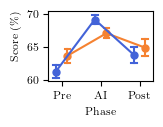

In [105]:
def plot_average_scores_pre_ai_post():
    local_participants = [participant_data for participant_data in participants_data if participant_data["aiType"] == "low"]
    global_participants = [participant_data for participant_data in participants_data if participant_data["aiType"] == "high"]
    
    phase_scores_local_ai = {
        "pre_treatment": [round_data["relativeScore"] for local_participant in local_participants for round_data in local_participant["preRounds"]],
        "ai": [round_data["relativeScore"] for local_participant in local_participants for round_data in local_participant["aiRounds"]],
        "post_treatment": [round_data["relativeScore"] for local_participant in local_participants for round_data in local_participant["postRounds"]]
    }
    phase_scores_global_ai = {
        "pre_treatment": [round_data["relativeScore"] for global_participant in global_participants for round_data in global_participant["preRounds"]],
        "ai": [round_data["relativeScore"] for global_participant in global_participants for round_data in global_participant["aiRounds"]],
        "post_treatment": [round_data["relativeScore"] for global_participant in global_participants for round_data in global_participant["postRounds"]]
    }
        
    def plot_setting(x_ticks, phase_performances, colour, offset_points, label):
        phase_means = []
        for phase_nr, phase in enumerate(["pre_treatment", "ai", "post_treatment"]):
            performances = phase_performances[phase]
            mean = statistics.mean(performances)
            phase_means.append(mean)
            std = statistics.stdev(performances)
            standard_error = std / sqrt(len(performances))

            horizontal_line_width = 0.15
            x = x_ticks[phase_nr] + offset_points
            
            left = x - horizontal_line_width / 2
            top = mean - standard_error
            right = x + horizontal_line_width / 2
            bottom = mean + standard_error
            if phase == "ai":
                label = None
            plt.plot([x, x], [top, bottom], color=colour, label=label)
            plt.plot([left, right], [top, top], color=colour)
            plt.plot([left, right], [bottom, bottom], color=colour)
            plt.plot(x, mean, 'o', color=colour, markersize=5)
        plt.plot([x_tick + offset_points for x_tick in x_ticks], phase_means, color=colour)
        return
    
    xticks = [1, 2, 3]
    plt.xticks(xticks, ["Pre", "AI", "Post"])
    local_offset = 0.15
    plot_setting(xticks, phase_scores_local_ai, plot_colours["local"], local_offset, "local")
    global_offset = -0.15
    plot_setting(xticks, phase_scores_global_ai, plot_colours["global"], global_offset, "global")
    # plt.legend(loc="lower left")
    plt.xlabel("Phase", labelpad=8, verticalalignment="center")
    plt.ylabel("Score (\%)", loc='top')
    plt.gca().yaxis.set_major_locator(MultipleLocator(base=5))
    set_axes_length(plot_width, plot_height)
    plt.savefig("../figures/analysis_101/local_vs_global_by_phases.pdf", bbox_inches='tight')
    plt.show()
    
plot_average_scores_pre_ai_post()

#### Mixed effects model: Predict participants' scores
##### Model assumption
score ~ group * phase + pre_score
- score: a participant's score in a round
- group: the AI condition (local or global)
- phase: the phase of the experiment (pre-treatment, AI, or post-treatment)
- pre_score: the participant's mean score in the pre-treatment phase
- group * phase: the interaction between the AI condition and the phase
- random effect is added for each participant via participant_id
##### Results interpretation
- **In the AI phase, the local group scores 3.043 points lower than the global group. The Pre scores were controlled for. The effect is significant (p = 0.013).**
- Controlling for group and Pre scores, scores in the AI phase are significantly higher than in the Post phase (p < 0.001).
- Controlling for group and Pre scores, scores in the AI phase are significantly higher than in the Pre phase (p < 0.001).
- The drop in scores observed in the Post phase relative to the AI phase is less severe for the local group than for the global group. The effect isn't significant (p = 0.085).
- The increase in score from the Pre to the AI phase is more pronounced for the global group than for the local group. The effect is significant (p = 0.014).
- Controlling for group and phase, the Pre scores strongly predict all scores (p < 0.001).

In [106]:
def predict_participant_score_mixed_effects_model():
    participant_ids = []
    groups = []
    phases = []
    scores = []
    mean_pre_scores = []
    
    for participant_data in participants_data:
        participant_id = participant_data["id"]
        group = participant_data["aiType"]
        mean_pre_score = statistics.mean([round_data["relativeScore"] for round_data in participant_data["preRounds"]])
        for phase in ["pre", "ai", "post"]:
            for round_data in participant_data[f"{phase}Rounds"]:
                participant_ids.append(participant_id)
                groups.append(group)
                phases.append(phase)
                scores.append(round_data["relativeScore"])
                mean_pre_scores.append(mean_pre_score)
    
    data = pd.DataFrame({
        'participant_id': participant_ids,
        'group': groups,
        'phase': phases,
        'score': scores,
        'pre_score': mean_pre_scores,
    })
    
    model = mixedlm(
        "score ~ group * phase + pre_score",  # formula: dependent variable ~ fixed effects
        data,
        groups=data["participant_id"],  # random effects (participant-level intercepts)
    )
    
    result = model.fit(method="powell")
    print(result.summary())
    
predict_participant_score_mixed_effects_model()

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     score     
No. Observations:       1164        Method:                 REML      
No. Groups:             97          Scale:                  156.9588  
Min. group size:        12          Log-Likelihood:         -4613.8868
Max. group size:        12          Converged:              Yes       
Mean group size:        12.0                                          
----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------
Intercept                  43.663    3.969 11.001 0.000  35.884 51.442
group[T.low]               -3.043    1.229 -2.477 0.013  -5.451 -0.635
phase[T.post]              -5.291    1.229 -4.307 0.000  -7.699 -2.883
phase[T.pre]               -7.811    1.229 -6.359 0.000 -10.219 -5.404
group[T.low]:phase[T.po

### Rewards

#### Plot: Reward per trial in the AI phase

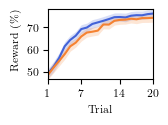

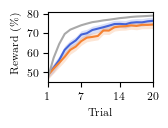

In [107]:
def plot_participant_reward_per_trial(show=True):
    rewards_global = []
    rewards_local = []
    for participant_data in participants_data:
        for round_data in participant_data["aiRounds"]:
            rewards = [trial["relativeReward"] for trial in round_data["trials"]]
            if participant_data["aiType"] == "low":
                rewards_local.append(rewards)
            else:
                rewards_global.append(rewards)
    trial_numbers = list(range(1, 21))
    rewards_local = np.asarray(rewards_local)
    rewards_global = np.asarray(rewards_global)
    plt.plot(trial_numbers, np.mean(rewards_global, axis=0), label="global", color=plot_colours["global"])
    plt.plot(trial_numbers, np.mean(rewards_local, axis=0), label="local", color=plot_colours["local"])
    plt.gca().xaxis.set_major_locator(FixedLocator([1, 7, 14, 20]))
    plt.gca().yaxis.set_major_locator(MultipleLocator(base=10))
    std_global = np.std(rewards_global, axis=0)
    std_local = np.std(rewards_local, axis=0)
    ci_global = 1.96 * std_global / sqrt(len(rewards_global))
    ci_local = 1.96 * std_local / sqrt(len(rewards_local))
    plt.fill_between(trial_numbers, np.mean(rewards_global, axis=0) - ci_global, np.mean(rewards_global, axis=0) + ci_global, color=plot_colours["global"], alpha=0.2, linewidth=0.0)
    plt.fill_between(trial_numbers, np.mean(rewards_local, axis=0) - ci_local, np.mean(rewards_local, axis=0) + ci_local, color=plot_colours["local"], alpha=0.2, linewidth=0.0)
    plt.xlim(1, 20)
    if show:
        plt.ylim(min((np.mean(rewards_global, axis=0) - ci_global)[0], (np.mean(rewards_local, axis=0) - ci_global)[0]), max((np.mean(rewards_global, axis=0) + ci_global)[-1], (np.mean(rewards_local, axis=0) + ci_local)[-1]))
    plt.xlabel("Trial", labelpad=8, verticalalignment="center")
    plt.ylabel("Reward (\%)", loc='top')
    set_axes_length(plot_width, plot_height)
    if show:
        plt.savefig("../figures/analysis_101/reward_per_trial_ai_phase.pdf", bbox_inches='tight')
        plt.show()


def plot_participant_reward_per_trial_with_linear_regression():
    trial_numbers = list(range(1, 21))
    plot_participant_reward_per_trial(show=False)
    # plot the mean linear regression reward as a line
    with open(f"../outputs/linear_regression_performance/linear_regression.json", "r", encoding="utf-8") as file:
        linear_regression_data = json.load(file)
        linear_regression_means = linear_regression_data[0]["rewards_mean"]
        plt.plot(trial_numbers, linear_regression_means, color=plot_colours["distinctColours"][3], linestyle="-", label="linear regression")
    set_axes_length(plot_width, plot_height)
    plt.savefig("../figures/analysis_101/reward_per_trial_ai_phase_with_linear_regression.pdf", bbox_inches='tight')
    plt.show()
    
plot_participant_reward_per_trial()
plot_participant_reward_per_trial_with_linear_regression()

### AI adherence

#### Plot: Frequency of following the AI's suggestion per round vs. score

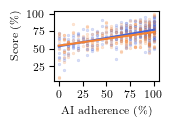

In [108]:
def plot_followed_ai_vs_score():
    participants_global = [participant_data for participant_data in participants_data if participant_data["aiType"] == "high"]
    participants_local = [participant_data for participant_data in participants_data if participant_data["aiType"] == "low"]
    followed_ai_local = [round_data["followedAiFrequency"] for participant_data in participants_local for round_data in participant_data["aiRounds"]]
    followed_ai_global = [round_data["followedAiFrequency"] for participant_data in participants_global for round_data in participant_data["aiRounds"]]
    scores_local = [round_data["relativeScore"] for participant_data in participants_local for round_data in participant_data["aiRounds"]]
    scores_global = [round_data["relativeScore"] for participant_data in participants_global for round_data in participant_data["aiRounds"]]

    local_line = np.polyfit(followed_ai_local, scores_local, 1)
    global_line = np.polyfit(followed_ai_global, scores_global, 1)
    xticks = np.linspace(0, 100, 1000)
    plt.plot(xticks, np.polyval(global_line, xticks), color=plot_colours["global"], label="global")
    plt.plot(xticks, np.polyval(local_line, xticks), color=plot_colours["local"], label="local")
    plt.scatter(followed_ai_global, scores_global, color=plot_colours["global"], s=15, alpha=0.2, marker=".", linewidths=0.4)
    plt.scatter(followed_ai_local, scores_local, color=plot_colours["local"], s=15, alpha=0.2, marker=".", linewidths=0.4)
    plt.gca().yaxis.set_major_locator(MultipleLocator(25))
    plt.gca().xaxis.set_major_locator(MultipleLocator(25))
    
    #plt.xlim(0, 100)
    #plt.ylim(0, 100)
    plt.xlabel("AI adherence (\%)", labelpad=8, verticalalignment="center")
    plt.ylabel("Score (\%)", loc='top')
    set_axes_length(plot_width, plot_height)
    plt.savefig("../figures/analysis_101/ai_followed_vs_score.pdf", bbox_inches='tight')
    plt.show()
    
plot_followed_ai_vs_score()

#### Plot: Frequency of following the AI's suggestion per trial

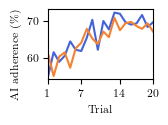

In [109]:
def plot_ai_followed_per_trial(show=True):
    ai_followed_global = []
    ai_followed_local = []
    for participant_data in participants_data:
        for round_data in participant_data["aiRounds"]:
            ai_followed = [trial["followedAi"] for trial in round_data["trials"]]
            if participant_data["aiType"] == "low":
                ai_followed_local.append(ai_followed)
            else:
                ai_followed_global.append(ai_followed)
    trial_numbers = list(range(1, 21))
    ai_followed_local = np.asarray(ai_followed_local)
    ai_followed_global = np.asarray(ai_followed_global)
    plt.plot(trial_numbers, np.mean(ai_followed_global, axis=0), label="global", color=plot_colours["global"])
    plt.plot(trial_numbers, np.mean(ai_followed_local, axis=0), label="local", color=plot_colours["local"])
    plt.xlim(1, 20)
    if show == True:
        plt.xlabel("Trial", labelpad=8, verticalalignment="center")
        plt.ylabel("AI adherence (\%)", loc='top')
        plt.gca().xaxis.set_major_locator(FixedLocator([1, 7, 14, 20]))
        plt.gca().yaxis.set_major_locator(MultipleLocator(base=10))
        set_axes_length(plot_width, plot_height)
        plt.savefig("../figures/analysis_101/ai_followed_per_trial.pdf", bbox_inches='tight')
        plt.show()
    
plot_ai_followed_per_trial()

#### Mixed effects model: Predict whether participants follow the AI's suggestion
##### Model assumption
ai_followed ~ group * trial
- ai_followed: whether the participant followed the AI's suggestion (0 or 100)
- group: the AI condition (local or global)
- trial: the trial number
- group * trial: the interaction between the AI condition and the trial
- random effect is added for each participant via participant_id
##### Results interpretation
- The local group is just as likely as the global group to follow the AI (p = 0.987).
- The increase in following over trials is slightly less pronounced for the local group than for the global group, but this interaction is not significant (p = 0.528).
- As trials progress, participants tend to follow the AI more often (p < 0.001).

In [110]:
def predict_participant_followed_ai_mixed_effects_model():
    participant_ids = []
    groups = []
    trial_nrs = []
    ai_followed_frequencies = []
    for participant_data in participants_data:
        participant_id = participant_data["id"]
        group = participant_data["aiType"]
        for round_data in participant_data["aiRounds"]:
            trial_nr = 1
            for trial in round_data["trials"]:
                participant_ids.append(participant_id)
                groups.append(group)
                trial_nrs.append(trial_nr)
                ai_followed_frequencies.append(trial["followedAi"])
                trial_nr += 1
    
    data = pd.DataFrame({
        'participant_id': participant_ids,
        'group': groups,
        'trial': trial_nrs,
        'ai_followed': ai_followed_frequencies,
    })
    
    model = mixedlm(
        "ai_followed ~ group * trial",  # formula: dependent variable ~ fixed effects
        groups=data["participant_id"],  # random effect for participants
        data=data
    )
    
    result = model.fit(method="powell")
    print(result.summary())
    
predict_participant_followed_ai_mixed_effects_model()

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  ai_followed
No. Observations:    11640    Method:              REML       
No. Groups:          97       Scale:               1839.1403  
Min. group size:     120      Log-Likelihood:      -60424.0270
Max. group size:     120      Converged:           Yes        
Mean group size:     120.0                                    
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           58.878    3.036 19.394 0.000 52.928 64.828
group[T.low]        -0.071    4.457 -0.016 0.987 -8.807  8.665
trial                0.682    0.094  7.246 0.000  0.498  0.867
group[T.low]:trial  -0.087    0.138 -0.630 0.528 -0.358  0.184
Group Var          413.123    1.455                           



### Counterfactual AI advisor

#### Plot: Frequency of following the counterfactual AI's suggestion per trial

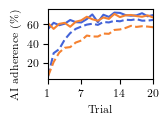

In [111]:
def plot_counterfactual_ai_followed_per_trial():
    other_ai_followed_global = []
    other_ai_followed_local = []
    for participant_data in participants_data:
        for round_data in participant_data["aiRounds"]:
            other_ai_followed = [trial["followedOtherAi"] for trial in round_data["trials"]]
            if participant_data["aiType"] == "low":
                other_ai_followed_local.append(other_ai_followed)
            else:
                other_ai_followed_global.append(other_ai_followed)
    trial_numbers = list(range(1, 21))
    plt.plot(trial_numbers, np.mean(other_ai_followed_global, axis=0), label="global", color=plot_colours["global"], linestyle="--")
    plt.plot(trial_numbers, np.mean(other_ai_followed_local, axis=0), label="local", color=plot_colours["local"], linestyle="--")
    # plt.legend(loc="lower right")
    plt.gca().xaxis.set_major_locator(FixedLocator([1, 7, 14, 20]))
    plt.gca().yaxis.set_major_locator(MultipleLocator(base=20))
    plt.xlim(1, 20)
    plt.xlabel("Trial", labelpad=8, verticalalignment="center")
    plt.ylabel("AI adherence (\%)", loc='top')
    set_axes_length(plot_width, plot_height)
    plt.savefig("../figures/analysis_101/counterfactual_ai_followed_per_trial.pdf", bbox_inches='tight')
    # also plot the actual AI adherence per trial
    plot_ai_followed_per_trial(show=False)
    set_axes_length(plot_width, plot_height)
    plt.savefig("../figures/analysis_101/both_ai_followed_per_trial.pdf", bbox_inches='tight')
    plt.show()
    
plot_counterfactual_ai_followed_per_trial()

#### Mixed effects model: Predict whether participants follow the counterfactual AI's suggestion
##### Model assumption
counterfactual_ai_followed ~ group * ai_followed + trial
- counterfactual_ai_followed: whether the participant followed the counterfactual AI's suggestion (0 or 100)
- group: the AI condition (local or global)
- trial: the trial number
- ai_followed: whether the participant followed the AI's suggestion (0 or 100)
- group * ai_followed: the interaction between the AI condition and the whether the actual AI's suggestion was followed
- random effect is added for each participant via participant_id
##### Results interpretation
- As trials progress, participants tend to follow the counterfactual AI more often (p < 0.001).
- Controlling for group and trial, participants are more likely to follow the counterfactual AI when they follow the actual AI (p < 0.001).
- The effect of following the actual AI's suggestion is weaker on the likelihood of following the counterfactual AI in the local group compared to the global group. The effect is significant (p < 0.001).

In [112]:
def predict_participant_followed_counterfactual_ai_mixed_effects_model():
    participant_ids = []
    groups = []
    trial_nrs = []
    ai_followeds = []
    counterfactual_ai_followeds = []
    for participant_data in participants_data:
        participant_id = participant_data["id"]
        group = participant_data["aiType"]
        for round_data in participant_data["aiRounds"]:
            trial_nr = 1
            for trial in round_data["trials"]:
                participant_ids.append(participant_id)
                groups.append(group)
                trial_nrs.append(trial_nr)
                ai_followeds.append(trial["followedAi"])
                counterfactual_ai_followeds.append(trial["followedOtherAi"])
                trial_nr += 1
    
    data = pd.DataFrame({
        'participant_id': participant_ids,
        'group': groups,
        'trial': trial_nrs,
        'counterfactual_ai_followed': counterfactual_ai_followeds,
        'ai_followed': ai_followeds,
    })
    
    model = mixedlm(
        "counterfactual_ai_followed ~ group * ai_followed + trial",  # formula: dependent variable ~ fixed effects
        groups=data["participant_id"],  # random effect for participants
        data=data
    )
    
    result = model.fit(method="powell")
    print(result.summary())
    
predict_participant_followed_counterfactual_ai_mixed_effects_model()

                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: counterfactual_ai_followed
No. Observations: 11640   Method:             REML                      
No. Groups:       97      Scale:              1463.6357                 
Min. group size:  120     Log-Likelihood:     -59072.8039               
Max. group size:  120     Converged:          Yes                       
Mean group size:  120.0                                                 
------------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------
Intercept                    12.260    2.136  5.741 0.000   8.074 16.446
group[T.low]                 -4.631    3.002 -1.543 0.123 -10.515  1.252
ai_followed                   0.348    0.011 30.568 0.000   0.326  0.370
group[T.low]:ai_followed     -0.066    0.016 -4.001 0.000  -0.098 -0.

#### Plot: Counterfactual AI value per trial

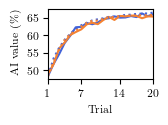

In [113]:
def plot_mean_counterfactual_ai_value_per_trial():
    ai_values_local = []
    ai_values_global = []
    counterfactual_ai_values_local = []
    counterfactual_ai_values_global = []
    for participant_data in participants_data:
        for round_data in participant_data["aiRounds"]:
            ai_values = [trial["relativeAiValue"] for trial in round_data["trials"]]
            counterfactual_ai_values = [trial["relativeOtherAiReward"] for trial in round_data["trials"]]
            if participant_data["aiType"] == "low":
                ai_values_local.append(ai_values)
                counterfactual_ai_values_local.append(counterfactual_ai_values)
            else:
                ai_values_global.append(ai_values)
                counterfactual_ai_values_global.append(counterfactual_ai_values)
    trial_numbers = list(range(1, 21))
    ai_values_local = np.asarray(ai_values_local)
    ai_values_global = np.asarray(ai_values_global)
    plt.plot(trial_numbers, np.mean(ai_values_global, axis=0), label="global", color=plot_colours["global"])
    plt.plot(trial_numbers, np.mean(ai_values_local, axis=0), label="local", color=plot_colours["local"])
    plt.plot(trial_numbers, np.mean(counterfactual_ai_values_global, axis=0), label="global counterfactual", color=plot_colours["global"], linestyle=":")
    plt.plot(trial_numbers, np.mean(counterfactual_ai_values_local, axis=0), label="local counterfactual", color=plot_colours["local"], linestyle=":")
    plt.gca().xaxis.set_major_locator(FixedLocator([1, 7, 14, 20]))
    plt.gca().yaxis.set_major_locator(MultipleLocator(base=5))
    plt.xlim(1, 20)
    plt.xlabel("Trial", labelpad=8, verticalalignment="center")
    plt.ylabel("AI value (\%)", loc='top')
    set_axes_length(plot_width, plot_height)
    plt.savefig("../figures/analysis_101/counterfactual_ai_value_per_trial.pdf", bbox_inches='tight')
    plt.show()
    
plot_mean_counterfactual_ai_value_per_trial()

#### Mixed effects model: Predict the counterfactual AI value
##### Model assumption
ai_value ~ group * ai_type
- ai_value: the mean reward associated with an AI suggestion
- group: the AI condition (local or global)
- ai_type: actual or counterfactual
- group * ai_type: the interaction between the AI type and the AI's suggestion value
- random effect is added for each participant via participant_id
##### Results interpretation
- The local group's AI value doesn't differ from the global group (p = 0.693).
- The difference between actual and counterfactual AI values does not significantly differ between local and global conditions (p = 0.439).

In [114]:
def predict_actual_and_counterfactual_ai_value_mixed_effects_model():
    participant_ids = []
    groups = []
    ai_values = []
    ai_types = []
    for participant_data in participants_data:
        participant_id = participant_data["id"]
        group = participant_data["aiType"]
        for round_data in participant_data["aiRounds"]:
            for trial in round_data["trials"]:
                participant_ids.append(participant_id)
                participant_ids.append(participant_id)
                groups.append(group)
                groups.append(group)
                ai_values.append(trial["relativeAiValue"])
                ai_values.append(trial["relativeOtherAiReward"])
                ai_types.append("actual")
                ai_types.append("counterfactual")
    
    data = pd.DataFrame({
        'participant_id': participant_ids,
        'group': groups,
        'ai_value': ai_values,
        'ai_type': ai_types,
    })
    
    model = mixedlm(
        "ai_value ~ group * ai_type",  # formula: dependent variable ~ fixed effects
        groups=data["participant_id"],  # random effect for participants
        data=data
    )
    
    result = model.fit(method="powell")
    print(result.summary())
    
predict_actual_and_counterfactual_ai_value_mixed_effects_model()

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         ai_value   
No. Observations:          23280           Method:                     REML       
No. Groups:                97              Scale:                      120.2691   
Min. group size:           240             Log-Likelihood:             -88947.2206
Max. group size:           240             Converged:                  Yes        
Mean group size:           240.0                                                  
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                              61.995    0.537 115.501 0.000 60.943 63.047
group[T.low]                           -0.088    0.788  -0.111 0.911 -1.632  1.457
ai_type[T.counterfactual]  

### Ratings

#### Plot: Participants' score vs AI rating

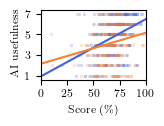

In [115]:
def plot_score_vs_rating():
    participants_global = [participant_data for participant_data in participants_data if participant_data["aiType"] == "high"]
    participants_local = [participant_data for participant_data in participants_data if participant_data["aiType"] == "low"]
    ratings_global = [round_data["usefulAiRound"] for participant_data in participants_global for round_data in participant_data["aiRounds"]]
    scores_global = [round_data["relativeScore"] for participant_data in participants_global for round_data in participant_data["aiRounds"]]
    ratings_local = [round_data["usefulAiRound"] for participant_data in participants_local for round_data in participant_data["aiRounds"]]
    scores_local = [round_data["relativeScore"] for participant_data in participants_local for round_data in participant_data["aiRounds"]]

    global_line = np.polyfit(scores_global, ratings_global, 1)
    local_line = np.polyfit(scores_local, ratings_local, 1)
    xticks = np.linspace(0, 100, 1000)
    plt.plot(xticks, np.polyval(global_line, xticks), color=plot_colours["global"], label="global")
    plt.plot(xticks, np.polyval(local_line, xticks), color=plot_colours["local"], label="local")
    plt.scatter(scores_global, ratings_global, color=plot_colours["global"], s=15, alpha=0.2, marker=".", linewidths=0.4)
    plt.scatter(scores_local, ratings_local, color=plot_colours["local"], s=15, alpha=0.2, marker=".", linewidths=0.4)
    plt.gca().yaxis.set_major_locator(FixedLocator([1, 3, 5, 7]))
    plt.gca().xaxis.set_major_locator(MultipleLocator(25))
    
    plt.xlim(0, 100)
    plt.ylim(0.6, 7.4)
    plt.xlabel("Score (\%)", labelpad=8, verticalalignment="center")
    plt.ylabel("AI usefulness", loc='top')
    set_axes_length(plot_width, plot_height)
    plt.savefig("../figures/analysis_101/human_score_vs_ai_rating.pdf", bbox_inches='tight')
    plt.show()
    
plot_score_vs_rating()

#### Mixed effects model: Predict participants' AI rating
##### Model assumption
rating ~ group * score + ai_followed
- rating: the participant's AI rating at the end of a round
- group: the AI condition (local or global)
- score: the participant's score in the round
- ai_followed: frequency of the participant following the AI's suggestion (0 to 100)
- group * score: the interaction between the AI condition and the score
- random effect is added for each participant via participant_id
##### Results interpretation
- Scores are predictive of AI ratings (p < 0.001).
- **While score positively predicts ratings in both groups, the relationship is significantly weaker for the local group (p = 0.022).**
- Following AI suggestions more frequently is associated with higher AI ratings (p < 0.001).

#### Mixed effects model: Predict participants' AI adherence rating
##### Model assumption
followed_ai_rating ~ group * ai_followed_frequency + group * usefulness_rating
- followed_ai_rating: the participant's rating of how often they followed the AI's suggestion
- group: the AI condition (local or global)
- ai_followed_frequency: the frequency of following the AI's suggestion in a round
- usefulness_rating: the participant's rating of how useful the AI's suggestions were
- group * ai_followed_frequency: the interaction between the AI condition and the frequency of following the AI's suggestion
- group * usefulness_rating: the interaction between the AI condition and the usefulness rating
- random effect is added for each participant via participant_id
##### Results interpretation
- **Participants in the local group rate following the AI's suggestions significantly lower than participants in the global group (p < 0.001).**
- Actual AI adherence and usefulness rating have no detectable effect on AI adherence rating, even when controlling for group (p = 1.000).

In [116]:
def predict_participant_followed_ai_rating_mixed_effects_model():
    participant_ids = []
    groups = []
    followed_ai_ratings = []
    ai_followed_frequencies = []
    usefulness_ratings = []
    for participant_data in participants_data:
        participant_id = participant_data["id"]
        group = participant_data["aiType"]
        followed_ai_rating = participant_data["followedAiRating"]
        for round_data in participant_data["aiRounds"]:
            followed_ai_frequency = round_data["followedAiFrequency"]
            usefulness_rating = round_data["usefulAiRound"]
            participant_ids.append(participant_id)
            groups.append(group)
            followed_ai_ratings.append(followed_ai_rating)
            ai_followed_frequencies.append(followed_ai_frequency)
            usefulness_ratings.append(usefulness_rating)
    
    data = pd.DataFrame({
        'participant_id': participant_ids,
        'group': groups,
        'followed_ai_rating': followed_ai_ratings,
        'ai_followed_frequency': ai_followed_frequencies,
        'usefulness_rating': usefulness_ratings,
    })
    
    model = mixedlm(
        "followed_ai_rating ~ group * ai_followed_frequency + group * usefulness_rating",  # formula: dependent variable ~ fixed effects
        groups=data["participant_id"],  # random effect for participants
        data=data
    )
    
    result = model.fit(method="powell")
    print(result.summary())
    
predict_participant_followed_ai_rating_mixed_effects_model()

                     Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      followed_ai_rating
No. Observations:       582          Method:                  REML              
No. Groups:             97           Scale:                   0.0000            
Min. group size:        6            Log-Likelihood:          7525.7542         
Max. group size:        6            Converged:               Yes               
Mean group size:        6.0                                                     
--------------------------------------------------------------------------------
                                   Coef.    Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                           4.500       0.111 40.430 0.000  4.282  4.718
group[T.low]                       -0.611       0.149 -4.102 0.000 -0.903 -0.319
ai_followed_frequency               0.000       0.

#### Ratings means and standard deviations

In [117]:
def print_ratings_means_and_std():
    usefulness_ratings_global = []
    usefulness_ratings_local = []
    usefulness_rounds_ratings_global = []
    usefulness_rounds_ratings_local = []
    adherence_ratings_global = []
    adherence_ratings_local = []
    for participant_data in participants_data:
        if participant_data["aiType"] == "low":
            usefulness_ratings_local.append(participant_data["usefulAiRating"])
            adherence_ratings_local.append(participant_data["followedAiRating"])
        else:
            usefulness_ratings_global.append(participant_data["usefulAiRating"])
            adherence_ratings_global.append(participant_data["followedAiRating"])
        for round_data in participant_data["aiRounds"]:
            if participant_data["aiType"] == "low":
                usefulness_rounds_ratings_local.append(round_data["usefulAiRound"])
            else:
                usefulness_rounds_ratings_global.append(round_data["usefulAiRound"])
    print("Final usefulness rating")
    print(f"Global: mean = {statistics.mean(usefulness_ratings_global)}, std = {statistics.stdev(usefulness_ratings_global)}")
    print(f"Local: mean = {statistics.mean(usefulness_ratings_local)}, std = {statistics.stdev(usefulness_ratings_local)}")
    print("\nRound usefulness rating")
    print(f"Global: mean = {statistics.mean(usefulness_rounds_ratings_global)}, std = {statistics.stdev(usefulness_rounds_ratings_global)}")
    print(f"Local: mean = {statistics.mean(usefulness_rounds_ratings_local)}, std = {statistics.stdev(usefulness_rounds_ratings_local)}")
    print("\nAdherence rating")
    print(f"Global: mean = {statistics.mean(adherence_ratings_global)}, std = {statistics.stdev(adherence_ratings_global)}")
    print(f"Local: mean = {statistics.mean(adherence_ratings_local)}, std = {statistics.stdev(adherence_ratings_local)}")
    
print_ratings_means_and_std()

Final usefulness rating
Global: mean = 5, std = 1.5592859099663563
Local: mean = 4.555555555555555, std = 1.5602382620431516

Round usefulness rating
Global: mean = 4.785256410256411, std = 1.8079959766900107
Local: mean = 4.181481481481481, std = 1.8088047845819133

Adherence rating
Global: mean = 5.038461538461538, std = 1.4136801987628098
Local: mean = 4.777777777777778, std = 1.8076716426599073


### AI values

#### Plot: Average AI value vs participant reward (advice followed, not followed, and both)

AI advice followed


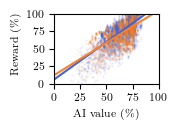

AI advice not followed


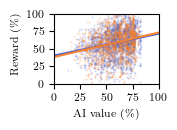

Both


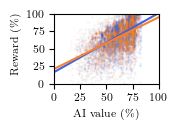

In [118]:
def plot_ai_vs_participant_reward():
    ai_values_global = []
    participant_rewards_global = []
    ai_values_local = []
    participant_rewards_local = []
    ai_followed_global = []
    ai_followed_local = []
    for participant_data in participants_data:
        for round_data in participant_data["aiRounds"]:
            for trial in round_data["trials"]:
                ai_value = trial["relativeAiValue"]
                participant_reward = trial["relativeReward"]
                ai_followed = trial["followedAi"]
                if participant_data["aiType"] == "low":
                    ai_values_local.append(ai_value)
                    participant_rewards_local.append(participant_reward)
                    ai_followed_local.append(ai_followed)
                else:
                    ai_values_global.append(ai_value)
                    participant_rewards_global.append(participant_reward)
                    ai_followed_global.append(ai_followed)    
    for followed_setting in ["followed", "not_followed", "both"]:
        if followed_setting == "both":
            print("Both")
            filename = "ai_vs_human_reward"
            ai_values_global_to_plot = ai_values_global[:]
            participant_rewards_global_to_plot = participant_rewards_global[:]
            ai_values_local_to_plot = ai_values_local[:]
            participant_rewards_local_to_plot = participant_rewards_local[:]
        elif followed_setting == "followed":
            print("AI advice followed")
            filename = "ai_vs_human_reward_ai_followed"
            ai_values_global_to_plot = [ai_values_global[i] for i in range(len(ai_values_global)) if ai_followed_global[i] == 100]
            participant_rewards_global_to_plot = [participant_rewards_global[i] for i in range(len(ai_values_global)) if ai_followed_global[i] == 100]
            ai_values_local_to_plot = [ai_values_local[i] for i in range(len(ai_values_local)) if ai_followed_local[i] == 100]
            participant_rewards_local_to_plot = [participant_rewards_local[i] for i in range(len(ai_values_local)) if ai_followed_local[i] == 100]
        else:
            print("AI advice not followed")
            filename = "ai_vs_human_reward_ai_not_followed"
            ai_values_global_to_plot = [ai_values_global[i] for i in range(len(ai_values_global)) if ai_followed_global[i] == 0]
            participant_rewards_global_to_plot = [participant_rewards_global[i] for i in range(len(ai_values_global)) if ai_followed_global[i] == 0]
            ai_values_local_to_plot = [ai_values_local[i] for i in range(len(ai_values_local)) if ai_followed_local[i] == 0]
            participant_rewards_local_to_plot = [participant_rewards_local[i] for i in range(len(ai_values_local)) if ai_followed_local[i] == 0]
        global_line = np.polyfit(ai_values_global_to_plot, participant_rewards_global_to_plot, 1)
        local_line = np.polyfit(ai_values_local_to_plot, participant_rewards_local_to_plot, 1)
        xticks = np.linspace(0, 100, 1000)
        plt.plot(xticks, np.polyval(global_line, xticks), color=plot_colours["global"], label="global")
        plt.plot(xticks, np.polyval(local_line, xticks), color=plot_colours["local"], label="local")
        nr_points = len(ai_values_global_to_plot) + len(ai_values_local_to_plot)
        plt.scatter(ai_values_global_to_plot, participant_rewards_global_to_plot, color=plot_colours["global"], s=2, alpha=1000/nr_points, linewidths=0)
        plt.scatter(ai_values_local_to_plot, participant_rewards_local_to_plot, color=plot_colours["local"], s=2, alpha=1000/nr_points, linewidths=0)
        plt.gca().xaxis.set_major_locator(FixedLocator([0, 25, 50, 75, 100]))
        plt.gca().yaxis.set_major_locator(FixedLocator([0, 25, 50, 75, 100]))
        plt.ylim(0, 100)
        plt.xlim(0, 100)
    
        plt.xlabel("AI value (\%)", labelpad=8, verticalalignment="center")
        plt.ylabel("Reward (\%)", loc='top')
        set_axes_length(plot_width, plot_height)
        plt.savefig(f"../figures/analysis_101/{filename}.pdf", bbox_inches='tight')
        plt.show()

plot_ai_vs_participant_reward()

#### Mixed effects model: Predict participants' reward when the AI suggestions are followed
##### Model assumption
participant_reward ~ group * ai_value + pre_score + max_participant_reward
- participant_reward: the participant's reward in a trial
- group: the AI condition (local or global)
- ai_value: the mean reward associated with an AI suggestion
- pre_score: the participant's mean score in the pre-treatment phase
- max_participant_reward: the maximum reward the participant has achieved so far in the round
- group * ai_value: the interaction between the AI condition and the AI's suggestion value
- random effect is added for each participant via participant_id
- only those trials are considered where the AI's suggestion was followed, and where trial_nr >= 2 (to have a max_participant_reward)
##### Results interpretation
- Greater participants rewards are strongly associated with greater AI values (p < 0.001).
- **Participants in the local group derive less benefit from greater AI values (p = 0.001).**
- Greater pre-scores are associated with greater participant rewards (p = 0.007).
- Greater maximum participant rewards are associated with greater participant rewards (p < 0.001).

In [119]:
def predict_participant_reward_when_ai_followed_mixed_effects_model():
    participant_ids = []
    groups = []
    participant_rewards = []
    max_participants_rewards_so_far = []
    ai_values = []
    pre_scores = []
    for participant_data in participants_data:
        participant_id = participant_data["id"]
        group = participant_data["aiType"]
        pre_score = statistics.mean([round_data["relativeScore"] for round_data in participant_data["preRounds"]])
        for round_data in participant_data["aiRounds"]:
            max_participant_reward = 0
            for trial_nr in range(len(round_data["trials"])):
                trial = round_data["trials"][trial_nr]
                if trial_nr == 0:
                    max_participant_reward = trial["relativeReward"]
                    continue
                participant_reward = trial["relativeReward"]
                ai_value = trial["relativeAiValue"]
                if trial["followedAi"] == 100:
                    participant_ids.append(participant_id)
                    groups.append(group)
                    participant_rewards.append(participant_reward)
                    ai_values.append(ai_value)
                    max_participants_rewards_so_far.append(max_participant_reward)
                    pre_scores.append(pre_score)
                if participant_reward > max_participant_reward:
                    max_participant_reward = participant_reward
    
    treatment_data = pd.DataFrame({
        'participant_id': participant_ids,
        'group': groups,
        'participant_reward': participant_rewards,
        'max_participant_reward': max_participants_rewards_so_far,
        'ai_value': ai_values,
        'pre_score': pre_scores,
    })
    
    model = mixedlm(
        "participant_reward ~ group * ai_value + pre_score + max_participant_reward",  # formula: dependent variable ~ fixed effects
        groups=treatment_data["participant_id"],  # random effect for participants
        data=treatment_data
    )
    
    result = model.fit(method="powell")
    print(result.summary())
    
predict_participant_reward_when_ai_followed_mixed_effects_model()

               Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  participant_reward
No. Observations:  7297     Method:              REML              
No. Groups:        97       Scale:               82.1752           
Min. group size:   20       Log-Likelihood:      -26540.2029       
Max. group size:   112      Converged:           Yes               
Mean group size:   75.2                                            
-------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------
Intercept              -13.371    2.437 -5.486 0.000 -18.148 -8.594
group[T.low]             2.679    1.445  1.853 0.064  -0.154  5.512
ai_value                 0.482    0.016 30.322 0.000   0.451  0.513
group[T.low]:ai_value   -0.071    0.021 -3.401 0.001  -0.111 -0.030
pre_score                0.098    0.036  2.695 0.007   0.027  0

#### Mixed effects model: Predict participants' reward when the AI suggestions are not followed
##### Model assumption
participant_reward ~ group * ai_value + pre_score + max_participant_reward
- participant_reward: the participant's reward in a trial
- group: the AI condition (local or global)
- ai_value: the mean reward associated with an AI suggestion
- pre_score: the participant's mean score in the pre-treatment phase
- max_participant_reward: the maximum reward the participant has achieved so far in the round
- group * ai_value: the interaction between the AI condition and the AI's suggestion value
- random effect is added for each participant via participant_id
- only those trials are considered where the AI's suggestion was followed, and where trial_nr >= 2 (to have a max_participant_reward)
##### Results interpretation
- When participants didn't follow the AI's suggestions, their rewards are negatively associated with the AI values (p = 0.007).
- The group didn't have a significant effect on the relationship between the AI values and the participants' rewards (p = 0.281).

In [120]:
def predict_participant_reward_when_ai_not_followed_mixed_effects_model():
    participant_ids = []
    groups = []
    participant_rewards = []
    max_participants_rewards_so_far = []
    ai_values = []
    pre_scores = []
    for participant_data in participants_data:
        participant_id = participant_data["id"]
        group = participant_data["aiType"]
        pre_score = statistics.mean([round_data["relativeScore"] for round_data in participant_data["preRounds"]])
        for round_data in participant_data["aiRounds"]:
            max_participant_reward = 0
            for trial_nr in range(len(round_data["trials"])):
                trial = round_data["trials"][trial_nr]
                if trial_nr == 0:
                    max_participant_reward = trial["relativeReward"]
                    continue
                participant_reward = trial["relativeReward"]
                ai_value = trial["relativeAiValue"]
                if trial["followedAi"] == 0:
                    participant_ids.append(participant_id)
                    groups.append(group)
                    participant_rewards.append(participant_reward)
                    ai_values.append(ai_value)
                    max_participants_rewards_so_far.append(max_participant_reward)
                    pre_scores.append(pre_score)
                if participant_reward > max_participant_reward:
                    max_participant_reward = participant_reward
    
    treatment_data = pd.DataFrame({
        'participant_id': participant_ids,
        'group': groups,
        'participant_reward': participant_rewards,
        'max_participant_reward': max_participants_rewards_so_far,
        'ai_value': ai_values,
        'pre_score': pre_scores,
    })
    
    model = mixedlm(
        "participant_reward ~ group * ai_value + pre_score + max_participant_reward",  # formula: dependent variable ~ fixed effects
        groups=treatment_data["participant_id"],  # random effect for participants
        data=treatment_data
    )
    
    result = model.fit(method="powell")
    print(result.summary())
    
predict_participant_reward_when_ai_not_followed_mixed_effects_model()

               Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  participant_reward
No. Observations:  3761     Method:              REML              
No. Groups:        97       Scale:               161.0549          
Min. group size:   2        Log-Likelihood:      -14987.4858       
Max. group size:   94       Converged:           Yes               
Mean group size:   38.8                                            
-------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------
Intercept              -10.935    5.044 -2.168 0.030 -20.821 -1.048
group[T.low]            -1.300    2.298 -0.566 0.572  -5.805  3.205
ai_value                -0.065    0.024 -2.691 0.007  -0.113 -0.018
group[T.low]:ai_value    0.036    0.033  1.078 0.281  -0.029  0.101
pre_score                0.406    0.077  5.276 0.000   0.255  0

#### Plot: Average AI value vs participant's reward (regression lines)

When AI was followed
Mean max participant reward: 77.25550368728165
Mean pre score: 62.37492843110562

When AI wasn't followed
Mean max participant reward: 66.46018876521656
Mean pre score: 62.468629826235265


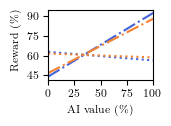

In [121]:
def plot_ai_vs_participant_reward_lines():
    followed_max_participants_rewards = []
    followed_pre_scores = []
    not_followed_max_participants_rewards = []
    not_followed_pre_scores = []
    for participant_data in participants_data:
        pre_score = statistics.mean([round_data["relativeScore"] for round_data in participant_data["preRounds"]])
        for round_data in participant_data["aiRounds"]:
            max_participant_reward = 0
            for trial_nr in range(len(round_data["trials"])):
                trial = round_data["trials"][trial_nr]
                if trial_nr == 0:
                    max_participant_reward = trial["relativeReward"]
                    continue
                participant_reward = trial["relativeReward"]
                if trial["followedAi"] == 100:
                    followed_max_participants_rewards.append(max_participant_reward)
                    followed_pre_scores.append(pre_score)
                else:
                    not_followed_max_participants_rewards.append(max_participant_reward)
                    not_followed_pre_scores.append(pre_score)
                if participant_reward > max_participant_reward:
                    max_participant_reward = participant_reward
    followed_mean_max_participant_reward = statistics.mean(followed_max_participants_rewards)
    not_followed_mean_max_participant_reward = statistics.mean(not_followed_max_participants_rewards)
    followed_mean_pre_score = statistics.mean(followed_pre_scores)
    not_followed_mean_pre_score = statistics.mean(not_followed_pre_scores)
    print("When AI was followed")
    print(f"Mean max participant reward: {followed_mean_max_participant_reward}")
    print(f"Mean pre score: {followed_mean_pre_score}")
    print("\nWhen AI wasn't followed")
    print(f"Mean max participant reward: {not_followed_mean_max_participant_reward}")
    print(f"Mean pre score: {not_followed_mean_pre_score}")
    followed_intercept_addition = 0.098 * followed_mean_pre_score + 0.665 * followed_mean_max_participant_reward
    not_followed_intercept_addition = 0.406 * not_followed_mean_pre_score + 0.729 * not_followed_mean_max_participant_reward
    global_followed_line = [0.482, -13.371 + followed_intercept_addition]
    local_followed_line = [0.482 - 0.071, -13.371 + 2.679 + followed_intercept_addition]
    global_not_followed_line = [-0.065, -10.935 + not_followed_intercept_addition]
    local_not_followed_line = [-0.065 + 0.036, -10.935 - 1.300 + not_followed_intercept_addition]
    xticks = np.linspace(0, 100, 1000)
    plt.plot(xticks, np.polyval(global_followed_line, xticks), color=plot_colours["global"], linestyle="-.", label="global followed")
    plt.plot(xticks, np.polyval(local_followed_line, xticks), color=plot_colours["local"], linestyle="-.", label="local followed")
    plt.plot(xticks, np.polyval(global_not_followed_line, xticks), color=plot_colours["global"], linestyle=":", label="global not followed")
    plt.plot(xticks, np.polyval(local_not_followed_line, xticks), color=plot_colours["local"], linestyle=":", label="local not followed")
    plt.xlabel("AI value (\%)", labelpad=8, verticalalignment="center")
    plt.ylabel("Reward (\%)", loc='top')
    plt.gca().xaxis.set_major_locator(FixedLocator([0, 25, 50, 75, 100]))
    plt.gca().yaxis.set_major_locator(MultipleLocator(15))
    #plt.ylim(50, 90)
    plt.xlim(0, 100)
    set_axes_length(plot_width, plot_height)
    plt.savefig(f"../figures/analysis_101/ai_vs_human_reward_lines.pdf", bbox_inches='tight')
    plt.show()

plot_ai_vs_participant_reward_lines()

#### Plot: Average AI value per trial

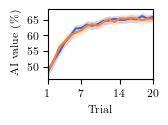

In [122]:
def plot_mean_ai_value_per_trial():
    ai_values_local = []
    ai_values_global = []
    for participant_data in participants_data:
        for round_data in participant_data["aiRounds"]:
            ai_values = [trial["relativeAiValue"] for trial in round_data["trials"]]
            if participant_data["aiType"] == "low":
                ai_values_local.append(ai_values)
            else:
                ai_values_global.append(ai_values)
    trial_numbers = list(range(1, 21))
    ai_values_local = np.asarray(ai_values_local)
    ai_values_global = np.asarray(ai_values_global)
    plt.plot(trial_numbers, np.mean(ai_values_global, axis=0), label="global", color=plot_colours["global"])
    plt.plot(trial_numbers, np.mean(ai_values_local, axis=0), label="local", color=plot_colours["local"])
    # plt.legend(loc="lower right")
    plt.gca().xaxis.set_major_locator(FixedLocator([1, 7, 14, 20]))
    plt.gca().yaxis.set_major_locator(MultipleLocator(base=5))
    std_global = np.std(ai_values_global, axis=0)
    std_local = np.std(ai_values_local, axis=0)
    ci_global = 1.96 * std_global / sqrt(len(ai_values_global))
    ci_local = 1.96 * std_local / sqrt(len(ai_values_local))
    plt.fill_between(trial_numbers, np.mean(ai_values_global, axis=0) - ci_global, np.mean(ai_values_global, axis=0) + ci_global, color=plot_colours["global"], alpha=0.2, linewidth=0.0)
    plt.fill_between(trial_numbers, np.mean(ai_values_local, axis=0) - ci_local, np.mean(ai_values_local, axis=0) + ci_local, color=plot_colours["local"], alpha=0.2, linewidth=0.0)
    plt.xlim(1, 20)
    plt.xlabel("Trial", labelpad=8, verticalalignment="center")
    plt.ylabel("AI value (\%)", loc='top')
    set_axes_length(plot_width, plot_height)
    plt.savefig("../figures/analysis_101/ai_value_per_trial.pdf", bbox_inches='tight')
    plt.show()
    
plot_mean_ai_value_per_trial()

#### Plot: Improvement on the AI's suggestion per trial

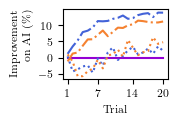

In [123]:
def plot_improvement_on_ai_per_trial():
    improvements_ai_followed_local = []
    improvements_ai_followed_global = []
    improvements_ai_not_followed_local = []
    improvements_ai_not_followed_global = []
    for participant_data in participants_data:
        for round_data in participant_data["aiRounds"]:
            improvements_ai_followed = []
            improvements_ai_not_followed = []
            for trial in round_data["trials"]:
                ai_value = trial["relativeAiValue"]
                participant_reward = trial["relativeReward"]
                ai_followed = trial["followedAi"]
                if ai_followed != 0:
                    improvements_ai_followed.append(participant_reward - ai_value)
                    improvements_ai_not_followed.append(np.nan)
                else:
                    improvements_ai_not_followed.append(participant_reward - ai_value)
                    improvements_ai_followed.append(np.nan)
            if participant_data["aiType"] == "low":
                improvements_ai_followed_local.append(improvements_ai_followed)
                improvements_ai_not_followed_local.append(improvements_ai_not_followed)
            else:
                improvements_ai_followed_global.append(improvements_ai_followed)
                improvements_ai_not_followed_global.append(improvements_ai_not_followed)
    
    trial_numbers = list(range(1, 21))
    improvements_ai_followed_local = np.asarray(improvements_ai_followed_local)
    improvements_ai_followed_global = np.asarray(improvements_ai_followed_global)
    improvements_ai_not_followed_local = np.asarray(improvements_ai_not_followed_local)
    improvements_ai_not_followed_global = np.asarray(improvements_ai_not_followed_global)
    plt.plot(trial_numbers, np.zeros(len(trial_numbers)), color=plot_colours["ai"], linestyle="-")
    plt.plot(trial_numbers, np.nanmean(improvements_ai_followed_global, axis=0), label="global", color=plot_colours["global"], linestyle="-.")
    plt.plot(trial_numbers, np.nanmean(improvements_ai_followed_local, axis=0), label="local", color=plot_colours["local"], linestyle="-.")
    plt.plot(trial_numbers, np.nanmean(improvements_ai_not_followed_global, axis=0), color=plot_colours["global"], linestyle=":")
    plt.plot(trial_numbers, np.nanmean(improvements_ai_not_followed_local, axis=0), color=plot_colours["local"], linestyle=":")
    plt.gca().xaxis.set_major_locator(FixedLocator([1, 7, 14, 20]))
    plt.gca().yaxis.set_major_locator(MultipleLocator(base=5))
    plt.xlabel("Trial", labelpad=8, verticalalignment="center")
    plt.ylabel("Improvement\non AI (\%)", loc='top')
    set_axes_length(plot_width, plot_height)
    plt.savefig("../figures/analysis_101/improvements_on_ai_per_trial.pdf", bbox_inches='tight')
    plt.show()

plot_improvement_on_ai_per_trial()

#### Mixed effects model: Predict the AI improvements
##### Model assumption
ai_improvement ~ group * ai_followed
- ai_improvement: the participant's improvement on the AI's suggestion in a trial
- group: the AI condition (local or global)
- ai_followed: whether the participant followed the AI's suggestion (binary)
- random effect is added for each participant via participant_id
##### Results interpretation
- The local AI group had slightly better improvement scores than the global AI group, but this difference was not significant (p = 0.236).
- Participants who followed the AI's suggestions had significantly better improvement scores than those who didn't (p < 0.001).
- The local AI group benefits significantly less from following AI than the global AI group (p < 0.001).

In [124]:
def predict_ai_improvement_mixed_effects_model():
    participant_ids = []
    ai_followed_binaries = []
    ai_improvements = []
    groups = []
    for participant_data in participants_data:
        participant_id = participant_data["id"]
        group = participant_data["aiType"]
        for round_data in participant_data["aiRounds"]:
            for trial_nr in range(len(round_data["trials"])):
                trial = round_data["trials"][trial_nr]
                ai_value = trial["relativeAiValue"]
                participant_reward = trial["relativeReward"]
                ai_followed = trial["followedAi"]
                participant_ids.append(participant_id)
                ai_followed_binaries.append(True if ai_followed == 100 else False)
                groups.append(group)
                ai_improvements.append(participant_reward - ai_value)
    
    treatment_data = pd.DataFrame({
        'participant_id': participant_ids,
        'group': groups,
        'ai_followed': ai_followed_binaries,
        'improvement_ai': ai_improvements,
    })
    
    model = mixedlm(
        "improvement_ai ~ group * ai_followed",  # formula: dependent variable ~ fixed effects
        groups=treatment_data["participant_id"],  # random effect for participants
        data=treatment_data
    )
    
    result = model.fit(method="powell")
    print(result.summary())
    
predict_ai_improvement_mixed_effects_model()

                   Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      improvement_ai
No. Observations:      11640        Method:                  REML          
No. Groups:            97           Scale:                   234.5292      
Min. group size:       120          Log-Likelihood:          -48403.6542   
Max. group size:       120          Converged:               Yes           
Mean group size:       120.0                                               
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        -0.217    0.783 -0.278 0.781 -1.751  1.316
group[T.low]                      1.357    1.146  1.185 0.236 -0.888  3.602
ai_followed[T.True]              11.112    0.454 24.468 0.000 10.221 12.002
group[T.low]:ai_followed[T.True

#### Mixed effects model: Predict the AI values
##### Model assumption
ai_value ~ group * trial
- ai_value: the mean reward associated with an AI suggestion
- group: the AI condition (local or global)
- trial: the trial number (between 1 and 20)
- group * trial: the interaction between the AI condition and the trial
- random effect is added for each participant via participant_id
##### Results interpretation
- **There is no strong evidence that the AI value (p = 0.778) or its relationship with trial (p = 0.355) differ significantly between the global and local groups.**
- The AI value increases as the trials progress (p < 0.001).

In [125]:
def predict_ai_value_mixed_effects_model():
    participant_ids = []
    groups = []
    trial_nrs = []
    ai_values = []
    for participant_data in participants_data:
        participant_id = participant_data["id"]
        group = participant_data["aiType"]
        for round_data in participant_data["aiRounds"]:
            for trial_nr in range(len(round_data["trials"])):
                trial = round_data["trials"][trial_nr]
                ai_value = trial["relativeAiValue"]
                trial_nrs.append(trial_nr + 1)
                participant_ids.append(participant_id)
                groups.append(group)
                ai_values.append(ai_value)
    
    treatment_data = pd.DataFrame({
        'participant_id': participant_ids,
        'group': groups,
        'trial': trial_nrs,
        'ai_value': ai_values,
    })
    
    model = mixedlm(
        "ai_value ~ group * trial",  # formula: dependent variable ~ fixed effects
        groups=treatment_data["participant_id"],  # random effect for participants
        data=treatment_data
    )
    
    result = model.fit(method="powell")
    print(result.summary())
    
predict_ai_value_mixed_effects_model()

            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  ai_value   
No. Observations:   11640    Method:              REML       
No. Groups:         97       Scale:               126.7762   
Min. group size:    120      Log-Likelihood:      -44838.6307
Max. group size:    120      Converged:           Yes        
Mean group size:    120.0                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          54.499    0.638 85.407 0.000 53.249 55.750
group[T.low]        0.265    0.937  0.283 0.778 -1.572  2.101
trial               0.714    0.025 28.881 0.000  0.665  0.762
group[T.low]:trial -0.034    0.036 -0.925 0.355 -0.105  0.038
Group Var          16.615    0.229                           



### Time

#### Plot: Average Pre, AI, Post completion times for the two settings

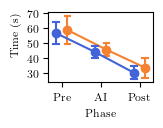

In [126]:
def plot_average_times_pre_ai_post():
    local_participants = [participant_data for participant_data in participants_data if participant_data["aiType"] == "low"]
    global_participants = [participant_data for participant_data in participants_data if participant_data["aiType"] == "high"]
    
    phase_times_local_ai = {
        "pre_treatment": [round_data["timeRound"] for local_participant in local_participants for round_data in local_participant["preRounds"]],
        "ai": [round_data["timeRound"] for local_participant in local_participants for round_data in local_participant["aiRounds"]],
        "post_treatment": [round_data["timeRound"] for local_participant in local_participants for round_data in local_participant["postRounds"]]
    }
    phase_times_global_ai = {
        "pre_treatment": [round_data["timeRound"] for global_participant in global_participants for round_data in global_participant["preRounds"]],
        "ai": [round_data["timeRound"] for global_participant in global_participants for round_data in global_participant["aiRounds"]],
        "post_treatment": [round_data["timeRound"] for global_participant in global_participants for round_data in global_participant["postRounds"]]
    }
        
    def plot_setting(x_ticks, phase_performances, colour, offset_points, label):
        phase_means = []
        for phase_nr, phase in enumerate(["pre_treatment", "ai", "post_treatment"]):
            performances = phase_performances[phase]
            mean = statistics.mean(performances)
            phase_means.append(mean)
            std = statistics.stdev(performances)
            confidence_interval = 1.96 * std / sqrt(len(performances))
            
            horizontal_line_width = 0.15
            x = x_ticks[phase_nr] + offset_points
            
            left = x - horizontal_line_width / 2
            top = mean - confidence_interval
            right = x + horizontal_line_width / 2
            bottom = mean + confidence_interval
            if phase == "ai":
                label = None
            plt.plot([x, x], [top, bottom], color=colour, label=label)
            plt.plot([left, right], [top, top], color=colour)
            plt.plot([left, right], [bottom, bottom], color=colour)
            plt.plot(x, mean, 'o', color=colour)
        plt.plot([x_tick + offset_points for x_tick in x_ticks], phase_means, color=colour)
        return
    
    xticks = [1, 2, 3]
    plt.xticks(xticks, ["Pre", "AI", "Post"])
    local_offset = 0.15
    plot_setting(xticks, phase_times_local_ai, plot_colours["local"], local_offset, "local")
    global_offset = -0.15
    plot_setting(xticks, phase_times_global_ai, plot_colours["global"], global_offset, "global")
    plt.xlabel("Phase", labelpad=8, verticalalignment="center")
    plt.ylabel("Time (s)", loc='top')
    plt.gca().yaxis.set_major_locator(MultipleLocator(base=10))
    set_axes_length(plot_width, plot_height)
    plt.savefig("../figures/analysis_101/local_vs_global_time_by_phases.pdf", bbox_inches='tight')
    plt.show()
    
plot_average_times_pre_ai_post()

#### Mixed effects model: Predict participants' completion times
##### Model assumption
time ~ group * phase + pre_time
- time: the time taken by a participant to complete a round
- group: the AI condition (local or global)
- phase: the phase of the experiment (pre-treatment, AI, or post-treatment)
- pre_time: the participant's mean time in the pre-treatment phase
- group * phase: the interaction between the AI condition and the phase
- random effect is added for each participant via participant_id
##### Results interpretation
- Participants take significantly longer in the Pre phase than in the AI phase (p < 0.001).
- Participants take significantly longer in the AI phase than in the Post phase (p < 0.001).
- Higher completion times are predictive of completion times in all phases (p < 0.001).
- **There is no significant difference in completion times between the local and global groups (p = 0.913, p = 0.685, p = 0.904).**

In [127]:
def predict_participant_time_mixed_effects_model():
    participant_ids = []
    groups = []
    phases = []
    times = []
    mean_pre_times = []
    
    for participant_data in participants_data:
        participant_id = participant_data["id"]
        group = participant_data["aiType"]
        mean_pre_time = statistics.mean([round_data["timeRound"] for round_data in participant_data["preRounds"]])
        for phase in ["pre", "ai", "post"]:
            for round_data in participant_data[f"{phase}Rounds"]:
                participant_ids.append(participant_id)
                groups.append(group)
                phases.append(phase)
                times.append(round_data["timeRound"])
                mean_pre_times.append(mean_pre_time)
    
    data = pd.DataFrame({
        'participant_id': participant_ids,
        'group': groups,
        'phase': phases,
        'time': times,
        'pre_time': mean_pre_times,
    })
    
    model = mixedlm(
        "time ~ group * phase + pre_time",  # formula: dependent variable ~ fixed effects
        data,
        groups=data["participant_id"],  # random effects (participant-level intercepts)
    )
    
    result = model.fit(method="powell")
    print(result.summary())
    
predict_participant_time_mixed_effects_model()

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      time      
No. Observations:      1164         Method:                  REML      
No. Groups:            97           Scale:                   843.3650  
Min. group size:       12           Log-Likelihood:          -5622.1517
Max. group size:       12           Converged:               Yes       
Mean group size:       12.0                                            
-----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------------
Intercept                   13.141    3.216  4.087 0.000   6.839 19.444
group[T.low]                 0.400    3.652  0.109 0.913  -6.759  7.558
phase[T.post]              -13.791    2.848 -4.843 0.000 -19.372 -8.210
phase[T.pre]                12.509    2.848  4.393 0.000   6.928 18.091
group[T.l

### Plot legend for the figures

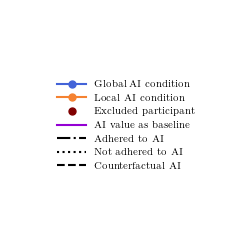

In [129]:
def plot_legend():
    global_ai = mlines.Line2D([], [], color=plot_colours["global"], marker="o", markersize=5, linestyle='-', label='Global AI condition')
    local_ai = mlines.Line2D([], [], color=plot_colours["local"], marker='o', markersize=5, linestyle='-', label='Local AI condition')
    outlier = mlines.Line2D([], [], color=plot_colours["distinctColours"][2], markersize = 5, marker='o', linestyle='', label='Excluded participant')
    ai_value_baseline = mlines.Line2D([], [], color=plot_colours["ai"], linestyle='-', label='AI value as baseline')
    ai_followed = mlines.Line2D([], [], color="black", linestyle='-.', label='Adhered to AI')
    ai_not_followed = mlines.Line2D([], [], color="black", linestyle=':', label='Not adhered to AI')
    other_ai_followed = mlines.Line2D([], [], color="black", linestyle='--', label='Counterfactual AI')

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.axis('off')
    ax.legend(handles=[global_ai, local_ai, outlier, ai_value_baseline, ai_followed, ai_not_followed, other_ai_followed], loc='center', frameon=False, handlelength=3, fontsize=7)

    plt.savefig("../figures/analysis_101/legend.pdf", bbox_inches='tight')
    plt.show()
    
plot_legend()